In [38]:
import cmdstanpy
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

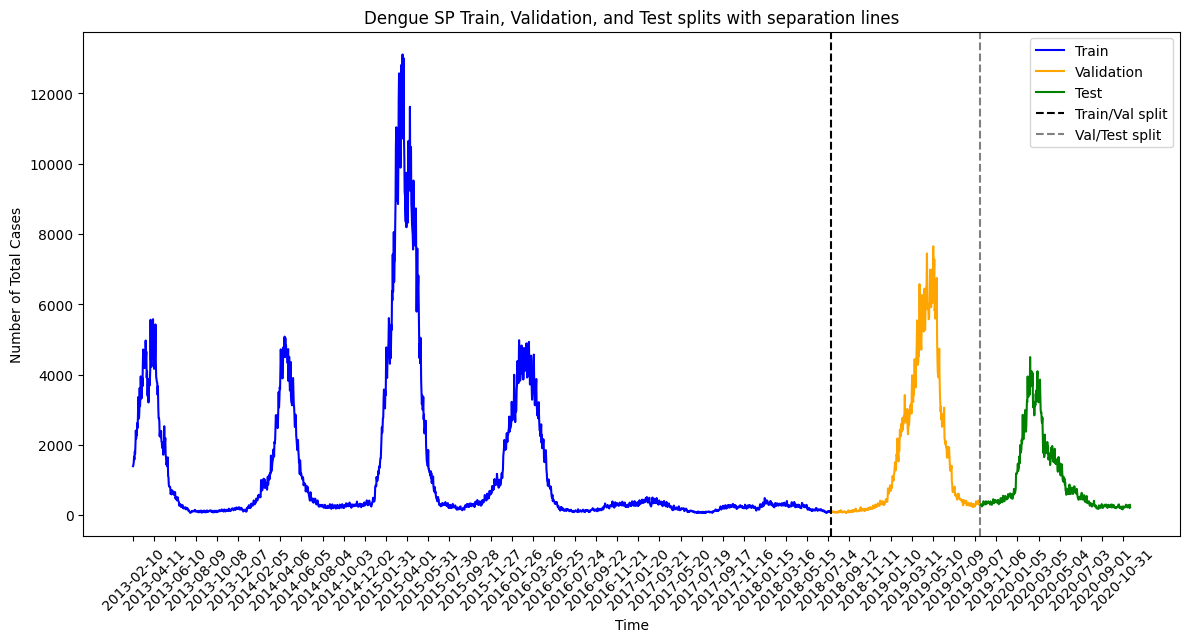

In [ ]:
project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv", index_col=0)
val_df = pd.read_csv(project_dir / "data" / "model" / "validation_data.csv", index_col=0)
test_df = pd.read_csv(project_dir / "data" / "model" / "test_data.csv", index_col=0)

# Load config vars
with open( project_dir / "config.yaml", 'r') as f:
    config = yaml.safe_load(f)

MAX_DELAY = config['model']['max_delay']



plt.figure(figsize=(12, 6))
# Plot train y
plt.plot(train_df.index, train_df['y'], label='Train', color='blue')

# Plot validation y, continuing x-axis after train
plt.plot(val_df.index[MAX_DELAY:], val_df['y'][MAX_DELAY:], label='Validation', color='orange')

# Plot test y
plt.plot(test_df.index[MAX_DELAY:], test_df['y'][MAX_DELAY:], label='Test', color='green')

# Add vertical lines at boundaries between train/val and val/test
# Assuming indices are numeric and increasing

# Get last x-value of train and val
train_end = train_df.index[-1]
val_end = val_df.index[-1]

plt.axvline(x=train_end, color='black', linestyle='--', label='Train/Val split')
plt.axvline(x=val_end, color='gray', linestyle='--', label='Val/Test split')

plt.xlabel('Time')
plt.ylabel('Number of Total Cases')
plt.title('Dengue SP Train, Validation, and Test splits with separation lines')
plt.legend()
plt.tight_layout()

ticks_positions = list(train_df.index) + list(val_df.index[MAX_DELAY:]) + list(test_df.index[MAX_DELAY:])


plt.xticks(ticks_positions[::60], rotation=45)

plt.show()


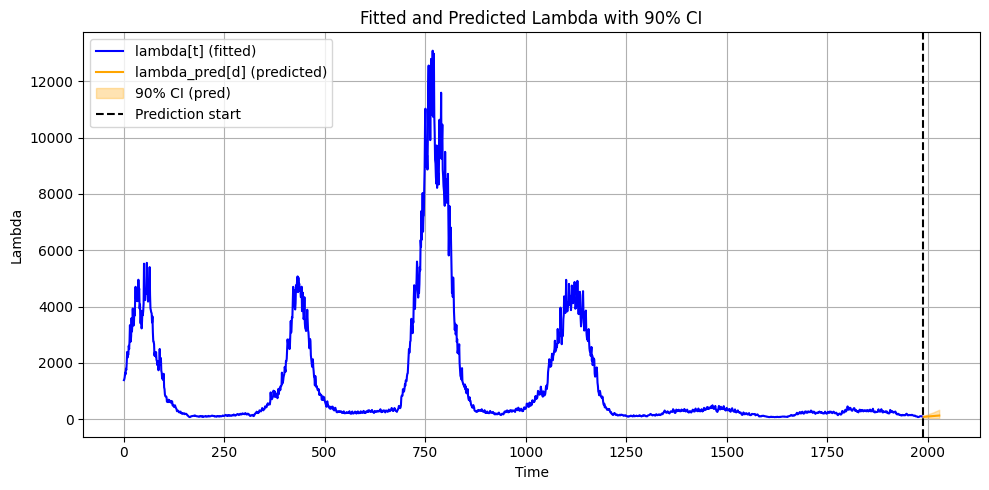

In [ ]:



stan_model_folder = project_dir / "src" / "outputs" / "stan_models" / "AR1_fit"

csv_files = [os.path.join(stan_model_folder, f)
             for f in os.listdir(stan_model_folder)
             if f.endswith('.csv')]

# Sort them to ensure consistent chain order (optional but recommended)
csv_files.sort()

# Load the CmdStanMCMC object from CSVs
fit = cmdstanpy.from_csv(path=csv_files)

# Extract full posterior draws
lambda_draws = fit.stan_variable('lambda')         # shape: (n_draws, T)
lambda_pred_draws = fit.stan_variable('lambda_pred')  # shape: (n_draws, D)

# Posterior means
lambda_mean = np.mean(lambda_draws, axis=0)
lambda_pred_mean = np.mean(lambda_pred_draws, axis=0)

# Credible intervals for prediction
lower_pred = np.percentile(lambda_pred_draws, 5, axis=0)
upper_pred = np.percentile(lambda_pred_draws, 95, axis=0)

# Time axes
T = len(lambda_mean)
D = len(lambda_pred_mean)
x_fitted = np.arange(1, T + 1)
x_pred = np.arange(T + 1, T + D + 1)

# Plot
plt.figure(figsize=(10, 5))

# Fitted line
plt.plot(x_fitted, lambda_mean, label='lambda[t] (fitted)', color='blue')

# Predicted line
plt.plot(x_pred, lambda_pred_mean, label='lambda_pred[d] (predicted)', color='orange')

# 90% credible interval for predictions
plt.fill_between(x_pred, lower_pred, upper_pred, color='orange', alpha=0.3, label='90% CI (pred)')

# Vertical separator
plt.axvline(x=T + 0.5, color='black', linestyle='--', label='Prediction start')

plt.xlabel('Time')
plt.ylabel('Lambda')
plt.title('Fitted and Predicted Lambda with 90% CI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
fit.metadata.stan_vars

{'alpha': Variable(name='alpha', start_idx=7, end_idx=8, dimensions=(), type=<VariableType.SCALAR: 1>, contents=[]),
 'beta': Variable(name='beta', start_idx=8, end_idx=9, dimensions=(), type=<VariableType.SCALAR: 1>, contents=[]),
 'sigma': Variable(name='sigma', start_idx=9, end_idx=10, dimensions=(), type=<VariableType.SCALAR: 1>, contents=[]),
 'lambda': Variable(name='lambda', start_idx=10, end_idx=1999, dimensions=(1989,), type=<VariableType.SCALAR: 1>, contents=[]),
 'lambda_pred': Variable(name='lambda_pred', start_idx=1999, end_idx=2039, dimensions=(40,), type=<VariableType.SCALAR: 1>, contents=[]),
 'y_pred': Variable(name='y_pred', start_idx=2039, end_idx=2079, dimensions=(40,), type=<VariableType.SCALAR: 1>, contents=[])}